In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
from helpers import preprocess_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.5.0+cpu
Torchvision Version: 0.6.0+cpu
GPU is available? False


In [58]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert to tensor and scale to [0, 1]
ts = transforms.Compose([transforms.ToTensor(), 
                             transforms.Normalize((0,), (1,))])
mnist_trainset = datasets.MNIST(root='data', train=True, download=True, transform=ts)
mnist_testset = datasets.MNIST(root='data', train=False, download=True, transform=ts)

In [48]:
N = len(mnist_trainset)
N_test = len(mnist_testset)

In [59]:
N

60000

In [45]:
x_train, y_train, y_one_hot, x_test, y_test, y_test_one_hot = preprocess_data(mnist_trainset,mnist_testset)

In [35]:
def initialize(dim_in, dim_out):
    W = 0.01*torch.randn(dim_out, dim_in, device=device)
    b = 0.1*torch.ones(dim_out, 1, device=device)
    return W, b

# Forward pass
def feed_forward(weight, bias, activation, dim = N):
    U = torch.addmm(bias.repeat(1, dim), weight, activation)
    V = nn.ReLU()(U)
    return U, V

In [36]:
def updateV(U1,U2,W,b,rho,gamma): 
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho*(torch.mm(torch.t(W),W)) + gamma*I), \
                     rho*torch.mm(torch.t(W),U2-b.repeat(1,col_U2)) + gamma*U1)
    return Vstar

In [37]:
def updateWb(U, V, W, b, alpha, rho): 
    d,N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha*W + rho*torch.mm(U - b.repeat(1,col_U),torch.t(V)),\
                     torch.inverse(alpha*I + rho*(torch.mm(V,torch.t(V)))))
    bstar = (alpha*b+rho*torch.sum(U-torch.mm(W,V), dim=1).reshape(b.size()))/(rho*N + alpha)
    return Wstar, bstar

In [38]:
def relu_prox(a, b, gamma, d, N):
    val = torch.empty(d,N, device=device)
    x = (a+gamma*b)/(1+gamma)
    y = torch.min(b,torch.zeros(d,N, device=device))

    val = torch.where(a+gamma*b < 0, y, torch.zeros(d,N, device=device))
    val = torch.where(((a+gamma*b >= 0) & (b >=0)) | ((a*(gamma-np.sqrt(gamma*(gamma+1))) <= gamma*b) & (b < 0)), x, val)
    val = torch.where((-a <= gamma*b) & (gamma*b <= a*(gamma-np.sqrt(gamma*(gamma+1)))), b, val)
    return val

In [39]:
gamma = 1
rho = 1
alpha = 1

In [40]:
def block_update(Wn, bn, Wn_1, bn_1, Vn, Un, Vn_1, Un_1, Vn_2, dn_1, alpha = alpha, gamma = gamma, rho = rho, dim = N):
    # update W(n) and b(n)
    Wn, bn = updateWb(Un, Vn_1, Wn, bn, alpha, rho)
    # update V(n-1)
    Vn_1 = updateV(Un_1, Un, Wn, bn, rho, gamma)
    # update U(n-1)
    Un_1 = relu_prox(Vn_1, (rho*torch.addmm(bn_1.repeat(1,dim), Wn_1, Vn_2) + \
                            alpha*Un_1)/(rho + alpha), (rho + alpha)/gamma, dn_1, dim)
    return Wn, bn, Vn_1, Un_1

In [63]:
d0 = x_d1*x_d2
d1 = d2 = d3 = 200
d4 = K 
W1, b1 = initialize(d0, d1)
b1.repeat(1,N).shape

torch.Size([200, 60000])

In [41]:
def compute_loss(weight, bias, activation, preactivation, rho = rho):
    loss = rho/2*torch.pow(torch.dist(torch.addmm(bias.repeat(1,N), \
                                                  weight, activation), preactivation, 2), 2).cpu().numpy()
    return loss

In [51]:
# Layers: input + 3 hidden + output
d0 = x_d1*x_d2
d1 = d2 = d3 = 200
d4 = K 


W1, b1 = initialize(d0, d1)
W2, b2 = initialize(d1, d2)
W3, b3 = initialize(d2, d3)
W4, b4 = initialize(d3, d4)


U1, V1 = feed_forward(W1, b1, x_train)
U2, V2 = feed_forward(W2, b2, V1)
U3, V3 = feed_forward(W3, b3, V2)
U4 = torch.addmm(b4.repeat(1, N), W4, V3)
V4 = U4

niter = 60
loss = np.empty(niter)
accuracy_train = np.empty(niter)
accuracy_test = np.empty(niter)

In [52]:
# Iterations
print('Train on', N, 'samples, validate on', N_test, 'samples')
for k in range(niter):
    start = time.time()

    # update V4
    V4 = (y_one_hot + gamma*U4 + alpha*V4)/(1 + gamma + alpha)
    
    # update U4
    U4 = (gamma*V4 + rho*(torch.mm(W4, V3) + b4.repeat(1,N)))/(gamma + rho)
    
    # update W4, b4, V3 and U3
    W4, b4, V3, U3 = block_update(W4, b4, W3, b3, V4, U4, V3, U3, V2, d3)
    
    # update W3, b3, V2 and U2
    W3, b3, V2, U2 = block_update(W3, b3, W2, b2, V3, U3, V2, U2, V1, d2)
    
    # update W2, b2, V1 and U1
    W2, b2, V1, U1 = block_update(W2, b2, W1, b1, V2, U2, V1, U1, x_train, d1)
    
    # update W1 and b1
    W1, b1 = updateWb(U1, x_train, W1, b1, alpha, rho)

    # compute updated training activations
    _, a1_train = feed_forward(W1, b1, x_train)
    _, a2_train = feed_forward(W2, b2, a1_train)
    _, a3_train = feed_forward(W3, b3, a2_train)
    
    
    # training prediction
    pred = torch.argmax(torch.addmm(b4.repeat(1, N), W4, a3_train), dim=0)
    #pred = torch.argmax(a4_train, dim=0)
    
    # compute test activations
    _, a1_test = feed_forward(W1, b1, x_test, N_test)
    _, a2_test = feed_forward(W2, b2, a1_test, N_test)
    _, a3_test = feed_forward(W3, b3, a2_test, N_test)

    # test/validation prediction    
    pred_test = torch.argmax(torch.addmm(b4.repeat(1, N_test), W4, a3_test), dim=0)
    
    # compute training loss
    loss[k] = gamma/2*torch.pow(torch.dist(V4,y_one_hot,2),2).cpu().numpy()
    
    # compute training accuracy
    correct_train = pred == y_train
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
    
    # compute validation accuracy
    correct_test = pred_test == y_test
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
    
    # print results
    print(f"Epoch: {k+1} / {niter} \n loss: {loss[k]:.4f} - acc:{accuracy_train[k]:.4f} - val_acc:{accuracy_test[k]:.4f}")

Train on 60000 samples, validate on 10000 samples
Epoch: 1 / 60 
 sq_loss: 12031.0732 - tot_loss: 12040.2182 - acc:0.7370 - val_acc:0.7506
Epoch: 2 / 60 
 sq_loss: 6760.1670 - tot_loss: 6763.8058 - acc:0.8313 - val_acc:0.8390


KeyboardInterrupt: 

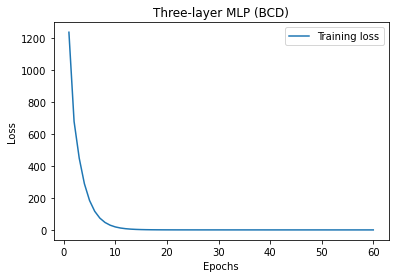

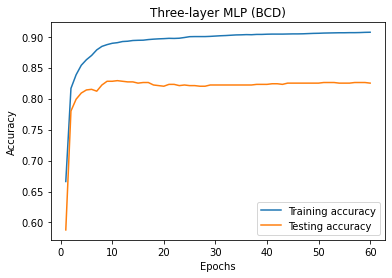

In [31]:
fig_loss = plt.figure(1)
plt.plot(np.arange(1, niter + 1), loss2, label='Training loss')
#plt.plot(np.arange(1, niter + 1), loss4, label='Validation loss')
plt.title('Three-layer MLP (BCD)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot of Accuracies
fig_accuracy = plt.figure(2)
plt.plot(np.arange(1, niter + 1), accuracy_train, label='Training accuracy', linewidth=1.5)
plt.plot(np.arange(1, niter + 1), accuracy_test, label='Testing accuracy', linewidth=1.5)
plt.title('Three-layer MLP (BCD)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()